# Federated Insurance

## Prerequisites
---

In [127]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split


from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_fed
#import FLutils

## Data preperation
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df.loc[:, [target]+features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


In [4]:
# create client data
# ==================

clients = [
    df.loc[df['region'] == x, [target] + features] for x in df['region'].unique()]

# or randomly
# clients = [df[[target] + features].sample(frac = 1./4, ignore_index = True) for _ in range(4)]

print("clients shape: %s" % [client.shape for client in clients])

clients shape: [(325, 10), (364, 10), (325, 10), (324, 10)]


## Evaluation split
---

In [5]:
# create evaluation splits
# ========================

nfolds, nreps = 5, 5

rsmp = RepeatedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)
client_splits = [list(rsmp.split(data)) for data in clients]


print("number of splits per client: %s" % [np.array(client, dtype = object).shape[0] for client in client_splits])

number of splits per client: [25, 25, 25, 25]


## Federated Learning
---

In [39]:
# define model architecture
def keras_blueprint(compile = False):
    return create_keras_model(
        nfeatures = 9, 
        units = [40, 40, 20], 
        activations = ['relu'] * 3, 
        compile = compile)

# Note: we do not compile the model yet. The loss, metrics, and optimizers are introduced later.
# S. https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#creating_a_model_with_keras

keras_blueprint().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 40)                400       
                                                                 
 dense_9 (Dense)             (None, 40)                1640      
                                                                 
 dense_10 (Dense)            (None, 20)                820       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


### Train

In [232]:
# compute train

results_fed = []

for eval_ind in tqdm.tqdm(range(nreps * nfolds)):

    # fetch train, eval data and prep it
    train_data_fed = []
    eval_data_fed  = []

    for client_ind in range(len(clients)):
        indices_train = client_splits[client_ind][eval_ind][0]

        data = clients[client_ind].iloc[indices_train]
        train_data, eval_data = train_test_split(data, test_size = 0.1, random_state = 42)

        train_data_fed.append(prep_fed_train(train_data[features], train_data[target])) 
        eval_data_fed.append(prep_fed_test(eval_data[features], eval_data[target]))
        
    # train
    result = train_fed(
        model = model_fn(keras_creator = keras_blueprint),
        train_data = train_data_fed,
        eval_data  = eval_data_fed,
        client_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer = lambda: tf.optimizers.Adam(learning_rate = .05),
        NUM_ROUNDS = 50,
        NUM_EPOCHS = 50,
        BATCH_SIZE = 128,
        SHUFFLE_BUFFER = 20,
        PREFETCH_BUFFER = 5,
        SEED = 42,
        verbose = True
    )

    results_fed.append(result)

  0%|          | 0/25 [00:00<?, ?it/s]2023-05-12 04:31:59.470842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:31:59.470901: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:31:59.470997: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:31:59.471307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:31:59.471362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5824.992, 'mean_squared_error': 102362640.0, 'loss': 5849.947, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14236.82, 'mean_squared_error': 367672000.0, 'loss': 14347.774, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5406.9956, 'mean_squared_error': 92689976.0, 'loss': 5429.6733, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14234.264, 'mean_squared_error': 367587550.0, 'loss': 14345.196, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5243.185, 'mean_squared_error': 88413140.0, 'loss': 5264.9497, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14226.108, 'mean_squared_error': 367316350.0, 'loss': 14337.005, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5082.358, 'mean_squared_error': 84319770.

  4%|▍         | 1/25 [00:21<08:27, 21.14s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2055.539, 'mean_squared_error': 23906656.0, 'loss': 2063.266, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3261.7632, 'mean_squared_error': 48068828.0, 'loss': 3262.0378, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:32:20.549912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.549974: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:32:20.550074: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:32:20.550481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.550554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:20.550605: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5774.101, 'mean_squared_error': 103512290.0, 'loss': 5798.176, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13158.367, 'mean_squared_error': 318678700.0, 'loss': 13195.894, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5335.9775, 'mean_squared_error': 92728040.0, 'loss': 5358.289, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13156.002, 'mean_squared_error': 318607900.0, 'loss': 13193.513, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5149.0684, 'mean_squared_error': 87764190.0, 'loss': 5170.509, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13148.48, 'mean_squared_error': 318379400.0, 'loss': 13185.974, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4957.9565, 'mean_squared_error': 83403670.

  8%|▊         | 2/25 [00:42<08:10, 21.32s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1925.7478, 'mean_squared_error': 22199268.0, 'loss': 1931.29, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2794.8887, 'mean_squared_error': 31925436.0, 'loss': 2781.5886, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:32:42.359501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.359576: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:32:42.359708: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:32:42.360089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.360152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:32:42.360196: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5852.1455, 'mean_squared_error': 102339340.0, 'loss': 5876.6953, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13153.374, 'mean_squared_error': 335924160.0, 'loss': 13195.758, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5452.373, 'mean_squared_error': 92711460.0, 'loss': 5475.121, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13150.924, 'mean_squared_error': 335850370.0, 'loss': 13193.292, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5271.4985, 'mean_squared_error': 88506280.0, 'loss': 5293.518, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13143.214, 'mean_squared_error': 335615420.0, 'loss': 13185.563, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5110.854, 'mean_squared_error': 84704184

 12%|█▏        | 3/25 [01:05<08:09, 22.25s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2152.8813, 'mean_squared_error': 26767240.0, 'loss': 2158.488, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3630.0117, 'mean_squared_error': 49154230.0, 'loss': 3705.9841, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:06.408793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.408847: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:06.408987: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:06.409371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.409444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:06.409493: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5773.9595, 'mean_squared_error': 100876460.0, 'loss': 5776.8604, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11251.445, 'mean_squared_error': 228382110.0, 'loss': 11243.027, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5372.0874, 'mean_squared_error': 91212370.0, 'loss': 5372.7363, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11248.965, 'mean_squared_error': 228319790.0, 'loss': 11240.531, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5208.153, 'mean_squared_error': 87151140.0, 'loss': 5207.895, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11241.208, 'mean_squared_error': 228124720.0, 'loss': 11232.769, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5049.2915, 'mean_squared_error': 832706

 16%|█▌        | 4/25 [01:29<07:54, 22.57s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2008.0793, 'mean_squared_error': 23397138.0, 'loss': 1993.3596, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2065.998, 'mean_squared_error': 25389980.0, 'loss': 2053.3464, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:28.154997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155063: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:28.155170: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:28.155538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:28.155654: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5957.9395, 'mean_squared_error': 104761416.0, 'loss': 5974.7026, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12941.683, 'mean_squared_error': 315933570.0, 'loss': 12956.155, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5577.3403, 'mean_squared_error': 95352840.0, 'loss': 5591.2197, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12939.274, 'mean_squared_error': 315862180.0, 'loss': 12953.731, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5357.732, 'mean_squared_error': 90480616.0, 'loss': 5370.6143, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12931.899, 'mean_squared_error': 315638500.0, 'loss': 12946.338, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5218.42, 'mean_squared_error': 8673293

 20%|██        | 5/25 [01:50<07:23, 22.18s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2176.2258, 'mean_squared_error': 26479878.0, 'loss': 2178.504, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 3076.379, 'mean_squared_error': 41249824.0, 'loss': 3057.8857, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:33:49.896572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.896635: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:33:49.896752: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:33:49.897093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.897154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:33:49.897196: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5851.5767, 'mean_squared_error': 103360870.0, 'loss': 5876.535, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13285.1, 'mean_squared_error': 320921150.0, 'loss': 13301.163, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5390.798, 'mean_squared_error': 92482420.0, 'loss': 5414.0166, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13282.682, 'mean_squared_error': 320846200.0, 'loss': 13298.73, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5245.3115, 'mean_squared_error': 88581540.0, 'loss': 5267.2993, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13275.121, 'mean_squared_error': 320609120.0, 'loss': 13291.155, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5079.585, 'mean_squared_error': 84539330.0

 24%|██▍       | 6/25 [02:11<06:55, 21.89s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2025.3456, 'mean_squared_error': 23968798.0, 'loss': 2031.1418, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2986.9302, 'mean_squared_error': 39253536.0, 'loss': 2945.72, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:34:11.201738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:11.201804: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:34:11.201922: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:34:11.202284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:11.202357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:11.202406: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5666.804, 'mean_squared_error': 98345990.0, 'loss': 5688.057, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14294.479, 'mean_squared_error': 355509150.0, 'loss': 14317.309, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5260.8203, 'mean_squared_error': 88636136.0, 'loss': 5279.314, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14291.942, 'mean_squared_error': 355426700.0, 'loss': 14314.765, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5045.1963, 'mean_squared_error': 84382296.0, 'loss': 5063.202, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14284.105, 'mean_squared_error': 355165570.0, 'loss': 14306.933, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4896.9434, 'mean_squared_error': 80683690.

 28%|██▊       | 7/25 [02:33<06:34, 21.93s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1996.7849, 'mean_squared_error': 23542408.0, 'loss': 2001.7374, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3184.5364, 'mean_squared_error': 41317400.0, 'loss': 3222.2666, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:34:33.022800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:33.022864: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:34:33.022966: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:34:33.023341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:33.023403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:33.023446: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5719.668, 'mean_squared_error': 99448560.0, 'loss': 5742.6675, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15775.135, 'mean_squared_error': 422512700.0, 'loss': 15911.568, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5301.2476, 'mean_squared_error': 89557480.0, 'loss': 5321.8584, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15772.617, 'mean_squared_error': 422422530.0, 'loss': 15909.035, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5159.946, 'mean_squared_error': 85919600.0, 'loss': 5179.338, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15764.675, 'mean_squared_error': 422133900.0, 'loss': 15901.07, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4997.4473, 'mean_squared_error': 81924520.

 32%|███▏      | 8/25 [02:54<06:08, 21.66s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2064.5295, 'mean_squared_error': 24104670.0, 'loss': 2069.2466, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 4179.6377, 'mean_squared_error': 60245050.0, 'loss': 4166.4775, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:34:54.251873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:54.251938: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:34:54.252042: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:34:54.252413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:54.252482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:34:54.252531: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5847.4834, 'mean_squared_error': 104714420.0, 'loss': 5854.3022, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13890.492, 'mean_squared_error': 337419700.0, 'loss': 13966.367, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5420.5635, 'mean_squared_error': 94022090.0, 'loss': 5424.7334, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13888.003, 'mean_squared_error': 337342000.0, 'loss': 13963.858, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5216.822, 'mean_squared_error': 89074300.0, 'loss': 5219.507, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13880.244, 'mean_squared_error': 337099140.0, 'loss': 13956.07, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5056.615, 'mean_squared_error': 85112424

 36%|███▌      | 9/25 [03:16<05:46, 21.64s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2036.5817, 'mean_squared_error': 24726514.0, 'loss': 2024.4421, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2566.5708, 'mean_squared_error': 26079488.0, 'loss': 2608.964, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:35:15.851111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:15.851170: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:35:15.851284: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:35:15.851580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:15.851637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:15.851679: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5808.9326, 'mean_squared_error': 102073590.0, 'loss': 5829.3325, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12123.807, 'mean_squared_error': 284840400.0, 'loss': 12140.954, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5374.2764, 'mean_squared_error': 91635384.0, 'loss': 5392.2036, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12121.461, 'mean_squared_error': 284777020.0, 'loss': 12138.592, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5208.9497, 'mean_squared_error': 87426030.0, 'loss': 5225.705, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12114.412, 'mean_squared_error': 284582100.0, 'loss': 12131.517, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5041.7437, 'mean_squared_error': 83644

 40%|████      | 10/25 [03:38<05:24, 21.65s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2001.3232, 'mean_squared_error': 23285326.0, 'loss': 2002.9756, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 2492.7126, 'mean_squared_error': 31974400.0, 'loss': 2476.7847, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:35:39.222480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:39.222537: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:35:39.222634: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:35:39.222959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:39.223032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:35:39.223084: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5858.5303, 'mean_squared_error': 104569544.0, 'loss': 5881.655, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13373.779, 'mean_squared_error': 322908500.0, 'loss': 13387.144, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5462.927, 'mean_squared_error': 94713064.0, 'loss': 5483.465, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13371.363, 'mean_squared_error': 322834800.0, 'loss': 13384.713, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5279.4995, 'mean_squared_error': 90056230.0, 'loss': 5299.0967, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13363.816, 'mean_squared_error': 322606100.0, 'loss': 13377.1455, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5114.9844, 'mean_squared_error': 860812

 44%|████▍     | 11/25 [04:01<05:09, 22.07s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2126.2563, 'mean_squared_error': 26413376.0, 'loss': 2131.1833, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2623.3079, 'mean_squared_error': 26134778.0, 'loss': 2598.3489, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:36:00.316319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:00.316392: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:36:00.316494: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:36:00.316810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:00.316868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:00.316908: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5609.2856, 'mean_squared_error': 94461890.0, 'loss': 5635.361, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15125.974, 'mean_squared_error': 404099550.0, 'loss': 15215.001, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5168.9214, 'mean_squared_error': 84707820.0, 'loss': 5191.7363, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15123.374, 'mean_squared_error': 404012480.0, 'loss': 15212.383, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 4979.8735, 'mean_squared_error': 80370750.0, 'loss': 5001.9707, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 15115.338, 'mean_squared_error': 403742270.0, 'loss': 15204.305, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4800.76, 'mean_squared_error': 76373050

 48%|████▊     | 12/25 [04:21<04:41, 21.66s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2007.4465, 'mean_squared_error': 23383718.0, 'loss': 2013.3673, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3771.5955, 'mean_squared_error': 61200136.0, 'loss': 3766.4285, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:36:21.228046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:21.228116: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:36:21.228208: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:36:21.228575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:21.228632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:21.228673: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5851.3584, 'mean_squared_error': 104008960.0, 'loss': 5875.514, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12871.334, 'mean_squared_error': 317739940.0, 'loss': 12813.642, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5420.3296, 'mean_squared_error': 93212580.0, 'loss': 5442.591, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12868.895, 'mean_squared_error': 317670900.0, 'loss': 12811.187, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5227.8066, 'mean_squared_error': 88538290.0, 'loss': 5248.6196, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12861.373, 'mean_squared_error': 317449280.0, 'loss': 12803.652, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5079.553, 'mean_squared_error': 8451124

 52%|█████▏    | 13/25 [04:43<04:18, 21.53s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2037.201, 'mean_squared_error': 23796796.0, 'loss': 2043.264, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3204.4053, 'mean_squared_error': 43709304.0, 'loss': 3197.6135, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:36:42.417351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:42.417407: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:36:42.417505: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:36:42.417827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:42.417883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:36:42.417923: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5889.064, 'mean_squared_error': 104626120.0, 'loss': 5884.4067, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12894.025, 'mean_squared_error': 292081400.0, 'loss': 13088.505, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5503.8804, 'mean_squared_error': 94872184.0, 'loss': 5497.64, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12891.596, 'mean_squared_error': 292010400.0, 'loss': 13086.052, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5304.7534, 'mean_squared_error': 90145300.0, 'loss': 5297.1597, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12884.014, 'mean_squared_error': 291787780.0, 'loss': 13078.423, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5152.683, 'mean_squared_error': 86081384

 56%|█████▌    | 14/25 [05:04<03:55, 21.42s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2111.5146, 'mean_squared_error': 25573392.0, 'loss': 2098.618, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2365.0334, 'mean_squared_error': 22425578.0, 'loss': 2432.215, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:37:03.633270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:03.633332: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:37:03.633435: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:37:03.633755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:03.633815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:03.633857: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5825.1836, 'mean_squared_error': 103874136.0, 'loss': 5845.438, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12080.332, 'mean_squared_error': 260476100.0, 'loss': 12193.774, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5404.684, 'mean_squared_error': 93513270.0, 'loss': 5422.838, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12077.962, 'mean_squared_error': 260410350.0, 'loss': 12191.382, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5261.2417, 'mean_squared_error': 89440960.0, 'loss': 5278.251, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 12070.523, 'mean_squared_error': 260204480.0, 'loss': 12183.904, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5120.4243, 'mean_squared_error': 85759890

 60%|██████    | 15/25 [05:25<03:33, 21.35s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2046.2644, 'mean_squared_error': 23707488.0, 'loss': 2048.7737, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 2855.1353, 'mean_squared_error': 33376460.0, 'loss': 2866.3694, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:37:24.834201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:24.834278: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:37:24.834416: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:37:24.834943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:24.835026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:24.835068: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5651.894, 'mean_squared_error': 98861420.0, 'loss': 5653.381, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13350.87, 'mean_squared_error': 313789250.0, 'loss': 13356.326, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5249.9688, 'mean_squared_error': 89079864.0, 'loss': 5248.017, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13348.557, 'mean_squared_error': 313719580.0, 'loss': 13354.0, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5049.732, 'mean_squared_error': 84461140.0, 'loss': 5047.058, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13341.063, 'mean_squared_error': 313490080.0, 'loss': 13346.505, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4910.3853, 'mean_squared_error': 80932440.0, '

 64%|██████▍   | 16/25 [05:46<03:12, 21.36s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1909.2263, 'mean_squared_error': 21915952.0, 'loss': 1915.531, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3636.9204, 'mean_squared_error': 53015790.0, 'loss': 3618.147, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:37:46.150500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:46.150557: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:37:46.150659: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:37:46.151046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:46.151123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:37:46.151168: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5945.4385, 'mean_squared_error': 106335220.0, 'loss': 5947.2305, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13037.064, 'mean_squared_error': 284884320.0, 'loss': 13124.892, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5538.34, 'mean_squared_error': 96078340.0, 'loss': 5538.171, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13034.594, 'mean_squared_error': 284813250.0, 'loss': 13122.4, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5345.517, 'mean_squared_error': 91237544.0, 'loss': 5344.5054, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13026.781, 'mean_squared_error': 284585920.0, 'loss': 13114.546, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5181.494, 'mean_squared_error': 86950250.0,

 68%|██████▊   | 17/25 [06:08<02:50, 21.37s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2092.65, 'mean_squared_error': 24784772.0, 'loss': 2078.2375, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2396.4646, 'mean_squared_error': 27724244.0, 'loss': 2375.9534, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:38:09.004043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:09.004098: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:38:09.004200: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:38:09.004539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:09.004599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:09.004641: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5931.377, 'mean_squared_error': 106789224.0, 'loss': 5956.564, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13433.113, 'mean_squared_error': 297471550.0, 'loss': 13432.316, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5526.4316, 'mean_squared_error': 96336030.0, 'loss': 5549.391, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13430.711, 'mean_squared_error': 297400480.0, 'loss': 13429.9, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5348.6997, 'mean_squared_error': 91663896.0, 'loss': 5370.8228, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13423.24, 'mean_squared_error': 297176200.0, 'loss': 13422.411, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5165.41, 'mean_squared_error': 87291680.0, 

 72%|███████▏  | 18/25 [06:30<02:31, 21.71s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2045.1721, 'mean_squared_error': 23749840.0, 'loss': 2051.3538, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 3464.7588, 'mean_squared_error': 44382510.0, 'loss': 3471.259, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:38:29.968093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:29.968146: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:38:29.968237: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:38:29.968637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:29.968726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:29.968841: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5791.849, 'mean_squared_error': 100691304.0, 'loss': 5813.4253, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14041.134, 'mean_squared_error': 377838500.0, 'loss': 14031.858, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5385.004, 'mean_squared_error': 91045650.0, 'loss': 5404.715, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14038.662, 'mean_squared_error': 377759040.0, 'loss': 14029.377, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5200.992, 'mean_squared_error': 86810860.0, 'loss': 5219.8125, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 14030.819, 'mean_squared_error': 377504060.0, 'loss': 14021.523, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5049.7812, 'mean_squared_error': 83064376

 76%|███████▌  | 19/25 [06:52<02:09, 21.63s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2083.9067, 'mean_squared_error': 25613512.0, 'loss': 2088.4358, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2997.8137, 'mean_squared_error': 40398476.0, 'loss': 2996.463, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:38:51.395242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:51.395305: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:38:51.395403: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:38:51.395778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:51.395834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:38:51.395874: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5596.3887, 'mean_squared_error': 97809336.0, 'loss': 5617.8296, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14576.85, 'mean_squared_error': 375578750.0, 'loss': 14732.664, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5209.8213, 'mean_squared_error': 88401370.0, 'loss': 5228.4697, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14574.402, 'mean_squared_error': 375496060.0, 'loss': 14730.194, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5069.86, 'mean_squared_error': 85168820.0, 'loss': 5087.4614, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14566.842, 'mean_squared_error': 375241760.0, 'loss': 14722.588, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4900.8823, 'mean_squared_error': 81279210

 80%|████████  | 20/25 [07:13<01:47, 21.55s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1976.443, 'mean_squared_error': 23169300.0, 'loss': 1979.4661, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 3072.4937, 'mean_squared_error': 36812456.0, 'loss': 3097.1692, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:39:12.924151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:12.924216: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:39:12.924317: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:39:12.924697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:12.924792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:12.924856: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5650.523, 'mean_squared_error': 99622904.0, 'loss': 5658.3745, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13792.789, 'mean_squared_error': 349523000.0, 'loss': 13872.462, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5231.2744, 'mean_squared_error': 89702580.0, 'loss': 5236.636, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13790.445, 'mean_squared_error': 349448260.0, 'loss': 13870.1, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5068.4893, 'mean_squared_error': 85518480.0, 'loss': 5073.0234, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 13783.057, 'mean_squared_error': 349209340.0, 'loss': 13862.683, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 4877.0825, 'mean_squared_error': 81251270.

 84%|████████▍ | 21/25 [07:35<01:26, 21.64s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1900.1848, 'mean_squared_error': 22324196.0, 'loss': 1887.836, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2883.9324, 'mean_squared_error': 35214870.0, 'loss': 2874.5225, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:39:35.660049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:35.660211: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:39:35.660406: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:39:35.661222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:35.661463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:35.661633: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5917.8823, 'mean_squared_error': 105393440.0, 'loss': 5941.803, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12761.147, 'mean_squared_error': 327567550.0, 'loss': 12877.111, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5508.0815, 'mean_squared_error': 95438056.0, 'loss': 5529.685, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12758.743, 'mean_squared_error': 327495870.0, 'loss': 12874.686, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5342.7354, 'mean_squared_error': 91215040.0, 'loss': 5363.3867, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 12751.229, 'mean_squared_error': 327268700.0, 'loss': 12867.136, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5162.415, 'mean_squared_error': 8677149

 88%|████████▊ | 22/25 [07:58<01:06, 22.05s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2083.5562, 'mean_squared_error': 24921394.0, 'loss': 2091.6147, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 1900.0447, 'mean_squared_error': 20061466.0, 'loss': 1907.0002, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:39:57.905280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:57.905352: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:39:57.905466: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:39:57.905871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:57.905943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:39:57.905994: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 6004.9775, 'mean_squared_error': 105375464.0, 'loss': 6007.9326, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11809.744, 'mean_squared_error': 240197380.0, 'loss': 11784.07, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5528.7837, 'mean_squared_error': 93995670.0, 'loss': 5528.7495, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11807.316, 'mean_squared_error': 240134450.0, 'loss': 11781.627, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5348.115, 'mean_squared_error': 89495590.0, 'loss': 5346.501, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11799.51, 'mean_squared_error': 239931060.0, 'loss': 11773.798, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5209.5015, 'mean_squared_error': 85800504

 92%|█████████▏| 23/25 [08:19<00:43, 21.74s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2202.7737, 'mean_squared_error': 27200082.0, 'loss': 2188.411, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2520.6992, 'mean_squared_error': 31002516.0, 'loss': 2530.2698, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:40:18.857995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:18.858056: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:40:18.858158: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:40:18.858535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:18.858606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:18.858656: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5840.5264, 'mean_squared_error': 102633680.0, 'loss': 5846.321, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11725.237, 'mean_squared_error': 264105180.0, 'loss': 11721.475, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5410.146, 'mean_squared_error': 92539550.0, 'loss': 5413.3633, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11722.901, 'mean_squared_error': 264042030.0, 'loss': 11719.123, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5245.826, 'mean_squared_error': 88417730.0, 'loss': 5248.672, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 11715.629, 'mean_squared_error': 263842640.0, 'loss': 11711.838, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5118.409, 'mean_squared_error': 85288584.

 96%|█████████▌| 24/25 [08:40<00:21, 21.46s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 2127.0374, 'mean_squared_error': 25785780.0, 'loss': 2114.9656, 'num_examples': 48100, 'num_batches': 378}
EVAL:  {'mean_absolute_error': 2965.5427, 'mean_squared_error': 34723296.0, 'loss': 2967.0964, 'num_examples': 108, 'num_batches': 4}


2023-05-12 04:40:39.504986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:39.505046: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-12 04:40:39.505139: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-12 04:40:39.505467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:39.505527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 04:40:39.505568: I tensor

====== ROUND  1 / 50 ======
TRAIN: {'mean_absolute_error': 5814.733, 'mean_squared_error': 104582010.0, 'loss': 5832.9297, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14216.234, 'mean_squared_error': 325717220.0, 'loss': 14279.808, 'num_examples': 108, 'num_batches': 4}
====== ROUND  2 / 50 ======
TRAIN: {'mean_absolute_error': 5380.0884, 'mean_squared_error': 93694024.0, 'loss': 5395.8335, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14213.748, 'mean_squared_error': 325638500.0, 'loss': 14277.306, 'num_examples': 108, 'num_batches': 4}
====== ROUND  3 / 50 ======
TRAIN: {'mean_absolute_error': 5197.053, 'mean_squared_error': 89547656.0, 'loss': 5211.551, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 14206.105, 'mean_squared_error': 325393570.0, 'loss': 14269.642, 'num_examples': 108, 'num_batches': 4}
====== ROUND  4 / 50 ======
TRAIN: {'mean_absolute_error': 5042.6763, 'mean_squared_error': 8552691

100%|██████████| 25/25 [09:00<00:00, 21.64s/it]

====== ROUND 50 / 50 ======
TRAIN: {'mean_absolute_error': 1974.3102, 'mean_squared_error': 22679244.0, 'loss': 1976.437, 'num_examples': 48200, 'num_batches': 379}
EVAL:  {'mean_absolute_error': 2831.7827, 'mean_squared_error': 34115384.0, 'loss': 2844.249, 'num_examples': 108, 'num_batches': 4}


In [233]:
# show final train result
pd.DataFrame([result['history'][-1] for result in results_fed]).describe().round(2)

,mean_absolute_error,mean_squared_error,loss,num_examples,num_batches,val_mean_absolute_error,val_mean_squared_error,val_loss,val_num_examples,val_num_batches
count,25.00,25.00,25.00,25.00,25.00,25.00,25.0,25.00,25.0,25.0
mean,2046.68,24295870.00,2046.48,48120.00,378.20,2949.17,37558220.0,2952.97,108.0,4.0
std,78.54,1478268.12,77.42,40.82,0.41,534.99,10939394.0,535.65,0.0,0.0
min,1900.18,21915952.00,1887.84,48100.00,378.00,1900.04,20061466.0,1907.00,108.0,4.0
25%,2001.32,23383718.00,2001.74,48100.00,378.00,2566.57,31002516.0,2598.35,108.0,4.0
50%,2045.17,23906656.00,2048.77,48100.00,378.00,2965.54,35214872.0,2945.72,108.0,4.0
75%,2092.65,25573392.00,2091.61,48100.00,378.00,3204.41,43709304.0,3222.27,108.0,4.0
max,2202.77,27200082.00,2188.41,48200.00,379.00,4179.64,61200136.0,4166.48,108.0,4.0


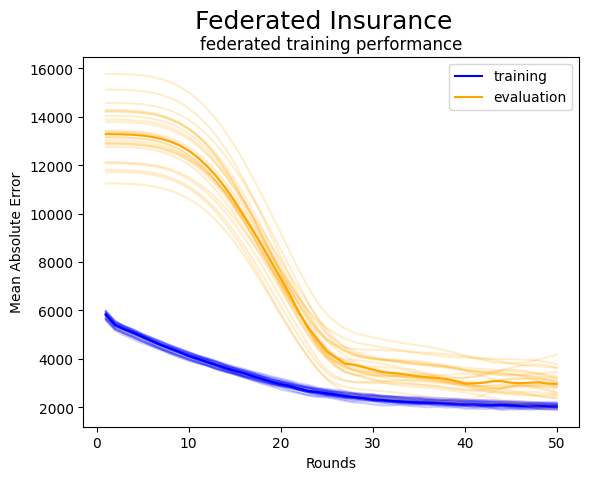

In [250]:
# plot train result

y = np.array([[hist['mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()
yval = np.array([[hist['val_mean_absolute_error'] for hist in res['history']] for res in results_fed]).transpose()


xran = range(1,y.shape[0] + 1)
plt.plot(xran, y, color = 'blue', alpha = .2)
plt.plot(xran, np.quantile(y,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(xran, yval, color = 'orange', alpha = .2)
plt.plot(xran, np.quantile(yval,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.xlabel("Rounds")
plt.ylabel("Mean Absolute Error")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('federated training performance')
plt.legend()
plt.show()

### Test

In [247]:
# compute test 
results_fed_test = []

for i in tqdm.tqdm(range(nfolds * nreps)):

    # fetch test data
    clients_test = []
    for client_ind in range(len(clients)):
        indices_test = client_splits[client_ind][eval_ind][1]
        clients_test.append(clients[client_ind].iloc[indices_test])

    test_data = pd.concat(clients_test)
    X_test = test_data[features]
    y_test = test_data[target]

    # calculate test performance
    model = keras_blueprint(compile = True)
    model_weights = results_fed[i]['process'].get_model_weights(results_fed[i]['state'])
    model_weights.assign_weights_to(model)
    
    perf_test = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))

    results_fed_test.append(perf_test)

100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


In [249]:
# show test results
pd.DataFrame(results_fed_test).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2944.918291,2944.918281,3.876515e+07,0.649169
std,239.899075,239.899077,4.279132e+06,0.036046
min,2622.776855,2622.776855,3.365351e+07,0.563300
25%,2764.888184,2764.888184,3.641308e+07,0.638991
50%,2914.515625,2914.515625,3.740965e+07,0.658135
75%,3023.657227,3023.657227,3.905585e+07,0.670424
max,3545.778320,3545.778320,4.924187e+07,0.701103


## Centralized DNN
---

### Train
---

In [126]:
# compute train
results_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    train_indices = [split[1][0] for split in client_splits]
    #test_indices = [split[1][1] for split in client_splits]

    data_train = pd.concat([clients[i].iloc[train_indices[i]] for i in range(len(clients))])
    X_train = data_train[features]
    y_train = data_train[target]

    model = keras_blueprint(compile = True)
    
    tf.keras.utils.set_random_seed(42)

    hist = model.fit(
        X_train, y_train,
        batch_size = 128, 
        shuffle    = True,
        validation_split = 0.2,
        epochs     = 100,
        verbose    = 2 # one line
        #, callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
    )
    results_ctr.append(hist)




Epoch 1/100
7/7 - 1s - loss: 11757.4658 - mae: 11757.4658 - mean_squared_error: 267746096.0000 - r2_score: -5.9795e-01 - val_loss: 6810.8086 - val_mae: 6810.8086 - val_mean_squared_error: 115696416.0000 - val_r2_score: 0.0494 - 651ms/epoch - 93ms/step
Epoch 2/100
7/7 - 0s - loss: 7546.5322 - mae: 7546.5322 - mean_squared_error: 141711552.0000 - r2_score: 0.1244 - val_loss: 7613.7568 - val_mae: 7613.7568 - val_mean_squared_error: 69502032.0000 - val_r2_score: 0.3784 - 476ms/epoch - 68ms/step
Epoch 3/100
7/7 - 1s - loss: 5207.7407 - mae: 5207.7407 - mean_squared_error: 61220440.0000 - r2_score: 0.6153 - val_loss: 8219.8740 - val_mae: 8219.8730 - val_mean_squared_error: 160644864.0000 - val_r2_score: -5.2958e-01 - 502ms/epoch - 72ms/step
Epoch 4/100
7/7 - 1s - loss: 5312.4185 - mae: 5312.4185 - mean_squared_error: 66068020.0000 - r2_score: 0.5888 - val_loss: 4869.2163 - val_mae: 4869.2163 - val_mean_squared_error: 54530160.0000 - val_r2_score: 0.4945 - 507ms/epoch - 72ms/step
Epoch 5/100


In [137]:
# show train results
pd.DataFrame(
    [{key: val[-1] for key, val in hist.history.items()} for hist in results_ctr]
    ).assign(
    r2_score    = lambda x: x.r2_score * 100,
    val_r2_score = lambda x: x.val_r2_score * 100
).describe()[1:].transpose().round(2)

,mean,std,min,25%,50%,75%,max
loss,1882.20,45.62,1816.59,1837.70,1871.13,1929.60,1978.26
mae,1882.20,45.62,1816.59,1837.70,1871.13,1929.60,1978.26
mean_squared_error,22575412.00,182654.90,22194692.00,22463032.00,22572410.00,22705954.00,22957338.00
r2_score,85.47,0.16,85.20,85.31,85.51,85.58,85.69
val_loss,2098.68,56.70,2015.46,2062.06,2083.06,2126.20,2241.18
val_mae,2098.68,56.70,2015.46,2062.06,2083.06,2126.20,2241.18
val_mean_squared_error,23525394.88,676013.91,22542178.00,22912234.00,23640880.00,23832380.00,25007960.00
val_r2_score,78.09,0.48,77.15,77.79,77.99,78.56,78.77


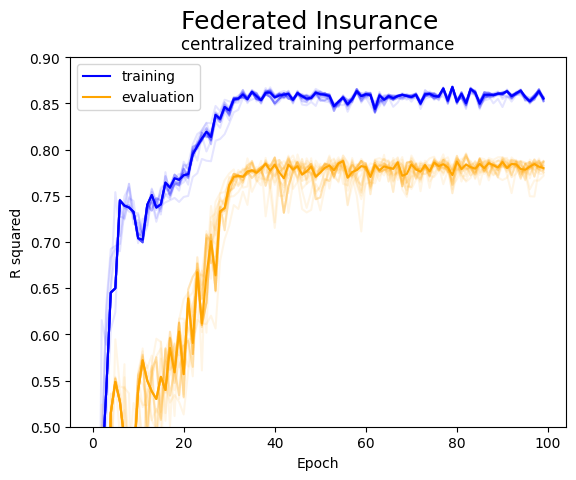

In [211]:
# plot train result
y1 = np.array([hist.history["r2_score"] for hist in results_ctr]).transpose()
y2 = np.array([hist.history["val_r2_score"] for hist in results_ctr]).transpose()

plt.plot(y1, color = 'blue', alpha = .1)
plt.plot(np.quantile(y1,.5, axis = 1), label = 'training', color = 'blue')
plt.plot(y2, color = 'orange', alpha = .1)
plt.plot(np.quantile(y2,.5, axis = 1), label = 'evaluation', color = 'orange')
plt.ylim([0.5, 0.9])
plt.xlabel("Epoch")
plt.ylabel("R squared")
plt.suptitle('Federated Insurance', fontsize=18)
plt.title('centralized training performance')
plt.legend()
plt.show()

### Test
---

In [176]:
# compute test
results_test_ctr = []

for i in tqdm.tqdm(range(nfolds * nreps)):
    #train_indices = [split[1][0] for split in client_splits]
    test_indices = [split[1][1] for split in client_splits]

    data_test = pd.concat([clients[i].iloc[test_indices[i]] for i in range(len(clients))])
    X_test = data_test[features]
    y_test = data_test[target]

    model = results_ctr[i].model
    perf_test  = model.evaluate(X_test, y_test, verbose = 0)
    perf_test = dict(zip(model.metrics_names, perf_test))
    results_test_ctr.append(perf_test)

100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


In [185]:
# show test results
pd.DataFrame(results_test_ctr).describe()[1:]

,loss,mae,mean_squared_error,r2_score
mean,2522.600625,2522.600625,3.365286e+07,0.647688
std,48.187150,48.187150,4.698439e+05,0.005468
min,2443.913330,2443.913330,3.242050e+07,0.640448
25%,2482.158447,2482.158447,3.335837e+07,0.643379
50%,2520.580078,2520.580078,3.375714e+07,0.645517
75%,2562.074707,2562.074707,3.394860e+07,0.651644
max,2606.295410,2606.295410,3.429384e+07,0.660304
